In [168]:
import numpy as np
import pandas as pd
import torch

import warnings

# Suppress  messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [169]:

train_csv_path=f"fashion-mnist_train.csv"


!ls

fashion_data.ipynb	 LICENSE    saved_models     Untitled-1.ipynb
fashion-mnist_test.csv	 README.md  test_project.py  venv
fashion-mnist_train.csv  runs	    training.py


In [170]:
TrainFashion_df = pd.read_csv(f"fashion-mnist_train.csv")
products = TrainFashion_df[['label']].to_numpy()
images  = TrainFashion_df.drop(['label'], axis=1).to_numpy()

In [171]:
images_reshaped = images.reshape(-1, 28, 28)
images_reshaped.shape

(60000, 28, 28)

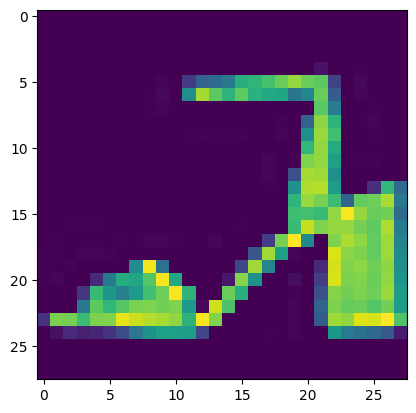

In [172]:
import matplotlib.pyplot as plt

plt.imshow(images_reshaped[60])

In [173]:
from torch.utils.data import Dataset
import pandas as pd

In [174]:
# Here we define our dataset - it is a map-style dataset, which means we have to know its size at initialisation and
# must be able to access data points at arbitrary locations. This is why the following methods must be implemented:
# __len__ and __getitem__
class FashionMNISTDataset(Dataset):
    def __init__(self, filepath: str):
        super().__init__()
        # Load data from CSV filepath defined earlier into a Pandas dataframe
        self.dataset = pd.read_csv(filepath)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset.iloc[index]

In [175]:
import multiprocessing as mp
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

In [176]:
def process_image (image):
    img = Image.open(f"{DATA_PREFIX}/" + image)
    return transform(img)

In [177]:
# item is referred to as pd_series because of the get_image_tensor function
def get_image_tensor(pd_series, threshold):
    img_tensor = torch.FloatTensor(pd_series.iloc[1:])
    img_tensor = img_tensor.reshape(1, 28, 28)
    #img_tensor = torch.where(img_tensor < threshold, 0, img_tensor)
    return img_tensor

In [214]:
def custom_collate_fn(batch):
    # Define a tensor of the same size as our image batch to store loaded images into
    image_batch_tensor = torch.FloatTensor(len(batch), 1, 28, 28)
    # Define empty lists to hold items we encounter
    image_tensors = []
    labels = []
    for item in batch:
        # load a single image
        image_tensor = get_image_tensor(item, threshold=80)
        # put image into a list
        image_tensors.append(image_tensor.unsqueeze(0))
        # put the same image's label into another list
        labels.append(item.iloc[0])


    # Concatenate the list of individual tensors (image_tensors) into a single Pytorch tensor (image_batch_tensor)
    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    # Use the label list to create a torch tensor of ints
    return image_batch_tensor, label_batch_tensor

In [180]:
def load_data(data_path, batch_sz=100, train_val_split=[0.7, 0.3]):
    assert sum(train_val_split) == 1, "Train and val fractions should sum to 1!"  # Always a good idea to use static asserts when processing arguments that are passed in by a user!
    # Instantiate our previously defined dataset
    dataset = FashionMNISTDataset(data_path)
    # split dataset into train and val
    tr_va = []
    for frac in train_val_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va.append(actual_count)

    train_split, val_split = random_split(dataset, tr_va)

     # Use Pytorch DataLoader to load each split into memory. It's important to pass in our custom collate function, so it knows how to interpret the
    # data and load it. num_workers tells the DataLoader how many CPU threads to use so that data can be loaded in parallel, which is faster

    # Get CPU count
    n_cpus = mp.cpu_count() # returns number of CPU cores on this machine
    train_dl = DataLoader(
        train_split,
        batch_size=batch_sz,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )

    val_dl = DataLoader(
        val_split,
        batch_size=batch_sz,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )

    return train_dl, val_dl


In [181]:
def image_grid(batch, ncols):
  height, width = batch[0].shape
  nrows = len(batch)//ncols

  image_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

  return image_grid

def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"

    result = image_grid(batch, cols)
    fig = plt.figure(figsize=(5., 5.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')

In [183]:
train_dl, val_dl = load_data(f"fashion-mnist_train.csv", batch_sz=16)

In [184]:
img_batch, label_batch = next(iter(train_dl))
print(img_batch.shape, label_batch.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


tensor([[1, 5, 5, 0],
        [4, 5, 5, 8],
        [9, 2, 6, 0],
        [4, 5, 8, 4]])


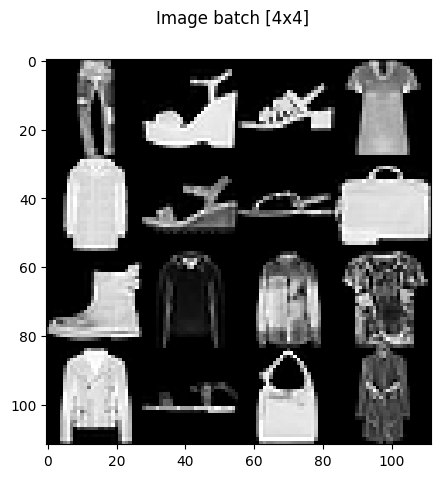

In [185]:
show_batch(img_batch.squeeze(1))
print(label_batch.reshape(4, 4))



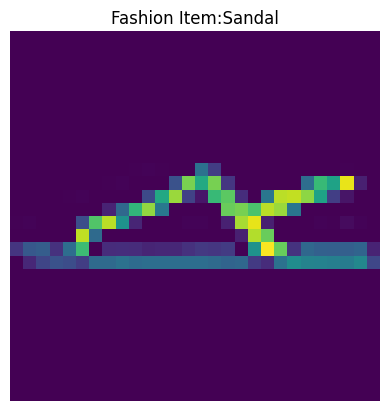

In [220]:
label_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
  }

def display_fashion_item_by_label(df, target_label):
  target_df = df[df['label']==target_label]

  if not target_df.empty:
     image_data = target_df.drop('label', axis =1).iloc[0].values.reshape(28,28)
     fashion_item = label_mapping[target_label]

     plt.imshow(image_data , vmin=0, vmax=255)
     plt.title(f'Fashion Item:{fashion_item}')
     plt.axis('off')
     plt.show()
  else:
     print(f'No images found for the label{target_label}')

display_fashion_item_by_label(TrainFashion_df, target_label=5)


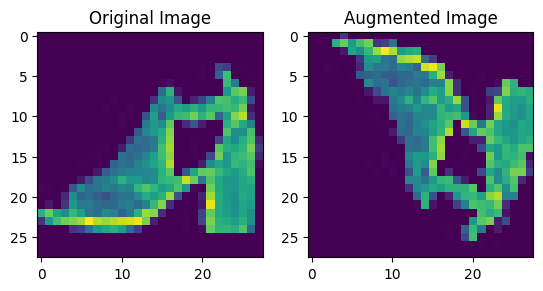

In [282]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a simple data augmentation using torchvision.transforms
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.RandomRotation(30),       # Randomly rotate the image up to 30 degrees
])

# Assume you have a dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])


# Create a dataset
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Assume you have a data loader with your custom collate function
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Your custom collate function
def custom_collate_fn(batch):
    # Define a tensor of the same size as our image batch to store loaded images into
    image_batch_tensor = torch.FloatTensor(len(batch), 1, 28, 28)
    # Define empty lists to hold items we encounter
    image_tensors = []
    labels = []
    for item in batch:
        # load a single image
        image_tensor = get_image_tensor(item, threshold=70)  # Replace with your implementation
        # put image into a list
        image_tensors.append(image_tensor.unsqueeze(0))
        # put the same image's label into another list
        labels.append(item.iloc[0])

    # Concatenate the list of individual tensors (image_tensors) into a single PyTorch tensor (image_batch_tensor)
    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    # Use the label list to create a torch tensor of ints
    return image_batch_tensor, label_batch_tensor

# Now, you can use the data loader with your custom collate function
for batch_idx, (images, labels) in enumerate(data_loader):
    # Apply data augmentation to the first image in the batch
    original_image = images[0]
    augmented_image = data_augmentation(original_image)

    # Display the original and augmented images for comparison
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image.squeeze().numpy())

    plt.subplot(1, 2, 2)
    plt.title('Augmented Image')
    plt.imshow(augmented_image.squeeze().numpy())

    plt.show()

    break  # Only process the first batch for illustration


In [227]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [229]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.softmax(out)
    return out


In [230]:
from torchvision import transforms
from PIL import Image

In [231]:
class EarlyStopper:
    def __init__(self, patience=3, tolerance=0):
       self.patience = patience # How many epochs in a row the model is allowed to underperform
       self.tolerance = tolerance # How much leeway the model has (i.e. how close it can get to underperforming before it is counted as such)
       self.epoch_counter = 0 # Keeping track of how many epochs in a row were failed
       self.max_val_acc = np.NINF # Keeping track of best metric so far

    def should_stop(self, val_acc):
        # print(f"current val max : {self.max_val_acc} , val acc : {val_acc}" )
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.epoch_counter = 0
        elif val_acc < (self.max_val_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False

In [232]:
from torch.optim.lr_scheduler import ExponentialLR
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dl, val_dl = load_data(f"fashion-mnist_train.csv", batch_sz=16)
n_input = 28*28
n_hidden = 128
n_classes = 10
epoch = 10


model = NeuralNetwork(n_input, n_hidden, n_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.0003, momentum =0.9)

gamma = 0.9 #gama is multiplied by the lr every epoch, decreasing the learning rate every time
schd = ExponentialLR(optimiser,gamma)

print(f"usig device: {DEVICE}")


usig device: cuda


In [233]:
from torch.utils.tensorboard import SummaryWriter

In [234]:
import os


# Saves a model to file, and names it after the current epoch
def save_checkpoint(model, model_name, epoch, save_dir):
    filename = f"{model_name}_checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save({'state_dict': model.state_dict()}, save_path)

In [235]:
from torch.utils.tensorboard import SummaryWriter




In [236]:


# Initialize EarlyStopper with a maximum of 3 epochs
early_stopper = EarlyStopper()

# Set your desired checkpoint frequency
def save_checkpoint(model, epoch, save_dir):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        # Add any other information you want to save
    }
    torch.save(checkpoint, os.path.join(save_dir, f'checkpoint_{epoch}.pth'))
# Initialize Tensorboard writer
writer = SummaryWriter()

def train_mlp(net, criterion, optimiser, train_dl, writer, epoch, stopper, checkpoint_frequency):
    running_loss = 0.0
    running_acc = 0.0
    net.train()

    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        batch_size = labels.shape[0]

        optimiser.zero_grad()
        inputs = inputs.reshape(batch_size, 28*28).to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        preds = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        correct = int(torch.eq(preds, labels).sum())

        running_acc += correct / batch_size
        running_loss += loss.item()
        

    epoch_loss = running_loss / len(train_dl)
    epoch_acc = running_acc / len(train_dl)
    return epoch_loss, epoch_acc

def val_mlp(net, criterion, val_dl):
    running_loss = 0.0
    running_acc = 0.0
    net.eval()

    for i, data in enumerate(val_dl, 0):
        with torch.no_grad():
            inputs, labels = data
            batch_size = labels.shape[0]
            labels = labels.to(DEVICE)

            inputs = inputs.reshape(batch_size, 28*28).to(DEVICE)
            outputs = net(inputs)
            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct = int(torch.eq(preds, labels).sum())

            running_acc += correct / batch_size
            running_loss += loss.item()

    epoch_loss = running_loss / len(val_dl)
    epoch_acc = running_acc / len(val_dl)

    return epoch_loss, epoch_acc


 # Set your desired checkpoint frequency
checkpoint_frequency = 1

for epoch in range(10):
    
    train_loss, train_acc = train_mlp(model, criterion, optimiser, train_dl, writer, epoch, early_stopper, checkpoint_frequency)
    val_loss, val_acc = val_mlp(model, criterion, val_dl)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    if epoch % checkpoint_frequency == 0:
        save_checkpoint(model, epoch, "saved_models")
    # Check whether we should stop the training based on the maximum epochs
    if early_stopper.should_stop(val_acc):
        print(f"\nStopping after {early_stopper.epoch_counter} epochs.")
        # If stopping, save the model's state
        save_checkpoint(model, epoch, "saved_models")
        break
    print(f"Epoch {epoch}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}")

print("Finished Training")

# Close Tensorboard writer
writer.close()


Epoch 0, train_loss: 2.064230425198873, train_acc: 0.39616666666666667, val_loss: 1.991017906083001, val_acc: 0.4696111111111111
Epoch 1, train_loss: 1.992737939335051, train_acc: 0.46795238095238095, val_loss: 1.9851511427561441, val_acc: 0.4756111111111111
Epoch 2, train_loss: 1.9883608285813104, train_acc: 0.47235714285714286, val_loss: 1.9874629084269206, val_acc: 0.4732222222222222
Epoch 3, train_loss: 1.9856543721698579, train_acc: 0.47509523809523807, val_loss: 1.9826366990407307, val_acc: 0.4781111111111111
Epoch 4, train_loss: 1.985255713644482, train_acc: 0.4753809523809524, val_loss: 1.9791639104419285, val_acc: 0.4817222222222222
Epoch 5, train_loss: 1.9620150528862363, train_acc: 0.49852380952380954, val_loss: 1.8910532845391168, val_acc: 0.5697222222222222
Epoch 6, train_loss: 1.8961411328088669, train_acc: 0.5648809523809524, val_loss: 1.88612947040134, val_acc: 0.5747222222222222
Epoch 7, train_loss: 1.8912718273798625, train_acc: 0.5695238095238095, val_loss: 1.8833252

In [237]:

# Define the CNN Module
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.relu3(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for fully connected layers
        
        x = x.view(x.size(0), -1)
        
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x






In [238]:
from torch.optim.lr_scheduler import ExponentialLR

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_input = 28*28
n_hidden = 128
n_classes = 10
cnn_model = CNN()
cnn_model = cnn_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(cnn_model.parameters(), lr=0.0003, momentum =0.9)

gamma = 0.9 #gama is multiplied by the lr every epoch, decreasing the learning rate every time
schd = ExponentialLR(optimiser,gamma)
epoch = 10


print(f"usig device: {DEVICE}")



usig device: cuda


In [239]:
# Initialize EarlyStopper with a maximum of 3 epochs
early_stopper = EarlyStopper()

def save_checkpoint(model, epoch, save_path):
    # Save the model's state dictionary along with other relevant information
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        # Add any other information you want to save, e.g., optimizer state, loss history, etc.
    }
    torch.save(checkpoint, os.path.join(save_path, f'cnn_checkpoint_{epoch}.pth'))


writer = SummaryWriter()

# Training loop
def train_cnn(net, criterion, optimiser, train_dl, writer, epoch, early_stopper, checkpoint_frequency):
    running_loss = 0.0
    running_acc = 0.0
    net.train()

    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        labels = labels.to(DEVICE)
        batch_sz = inputs.shape[0]

        optimiser.zero_grad()
        # Assuming you want to reshape inputs if needed
        inputs = inputs.reshape(batch_sz, 1, 28, 28).to(DEVICE)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        preds = torch.argmax(outputs, dim=1)
        correct = int(torch.eq(preds, labels).sum())

        running_acc += correct / len(labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dl)
    epoch_acc = running_acc / len(train_dl)

    return epoch_loss, epoch_acc

# Validation loop
def val_cnn(net, criterion, val_dl):
    running_loss = 0.0
    running_acc = 0.0
    net.eval()

    with torch.no_grad():
        for i, data in enumerate(val_dl, 0):
            inputs, labels = data
            labels =labels.to(DEVICE)
            batch_sz = inputs.shape[0]

            # Assuming you want to reshape inputs if needed
            inputs = inputs.reshape(batch_sz, 1, 28, 28).to(DEVICE)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            correct = int(torch.eq(preds, labels).sum())

            running_acc += correct / len(labels)
            running_loss += loss.item()

    epoch_loss = running_loss / len(val_dl)
    epoch_acc = running_acc / len(val_dl)

    return epoch_loss, epoch_acc

 # Set your desired checkpoint frequency
checkpoint_frequency = 1

for epoch in range(10):
    
    train_loss, train_acc = train_cnn(cnn_model, criterion, optimiser, train_dl, writer, epoch, early_stopper, checkpoint_frequency)
    val_loss, val_acc = val_cnn(cnn_model, criterion, val_dl)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    # Log loss and accuracy metrics using the writer so we can see them in Tensorboard
    # Check whether we need to save the model to a checkpoint file
    if epoch % checkpoint_frequency == 0:
        save_checkpoint(cnn_model, epoch, "saved_models")

    # Check whether we should stop the training based on the maximum epochs
    if early_stopper.should_stop(val_acc):
        print(f"\nStopping after {early_stopper.epoch_counter} epochs.")
        # If stopping, save the model's state
        save_checkpoint(cnn_model, epoch, "saved_models")
        break
    print(f"Epoch {epoch}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}")

print("Finished Training")

# close Tensorboard writer
writer.close()

Epoch 0, train_loss: 1.8283265200569516, train_acc: 0.6367619047619048, val_loss: 1.7692267785602145, val_acc: 0.6931111111111111
Epoch 1, train_loss: 1.7569031617300852, train_acc: 0.7047142857142857, val_loss: 1.748146080546909, val_acc: 0.7145555555555556
Epoch 2, train_loss: 1.7458773150216966, train_acc: 0.7158333333333333, val_loss: 1.7436809265348647, val_acc: 0.7161111111111111
Epoch 3, train_loss: 1.735497462181818, train_acc: 0.725452380952381, val_loss: 1.737071444829305, val_acc: 0.7246111111111111
Epoch 4, train_loss: 1.7299045015062604, train_acc: 0.7304285714285714, val_loss: 1.729448996649848, val_acc: 0.731
Epoch 5, train_loss: 1.7241337988717216, train_acc: 0.7363095238095239, val_loss: 1.732968071937561, val_acc: 0.7272777777777778
Epoch 6, train_loss: 1.7211019568670363, train_acc: 0.7387142857142858, val_loss: 1.7247852714326646, val_acc: 0.7352222222222222
Epoch 7, train_loss: 1.7182917076746622, train_acc: 0.7416904761904762, val_loss: 1.7233174738354153, val_acc

In [240]:
test_csv_path=f"fashion-mnist_test.csv"

In [241]:
def test_data_loader(test_csv_path, batch_sz=16):
    # Instantiate the test dataset
    test_dataset = FashionMNISTDataset(test_csv_path)

    # Use PyTorch DataLoader to load the test dataset into memory
    n_cpus = mp.cpu_count()
    
    # Check if the dataset is empty
    if len(test_dataset) == 0:
        raise ValueError("Test dataset is empty. Please check the CSV file or dataset loading logic.")

    test_dl = DataLoader(
        test_dataset,
        batch_size=batch_sz,
        shuffle=False,  # No need to shuffle the test set
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )

    return test_dl



In [242]:

# Function to calculate test accuracy and test loss
def test_model(model, dataloader, criterion, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(dataloader)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Loss: {average_loss:.4f}')

    return accuracy, average_loss

# Load the checkpoint
checkpoint = torch.load("saved_models/cnn_checkpoint_9.pth")

# Extract the model state_dict from the loaded checkpoint
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
elif 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint  # If no specific key is found, use the entire checkpoint

# Create a new instance of the model
num_classes = 10
cnn_model = CNN(num_classes)  # Replace with your CNN model class

# Load the model state_dict
cnn_model.load_state_dict(state_dict)

# Set your device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
cnn_model.to(DEVICE)

# Assuming you have a test dataloader (replace this with your actual dataloader)
test_csv_path = "fashion-mnist_test.csv"
test_dl = test_data_loader(test_csv_path, batch_sz=16)

# Specify the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Test the model and print accuracy and loss
test_accuracy, test_loss = test_model(cnn_model, test_dl, criterion, DEVICE)

Test Accuracy: 73.82%
Test Loss: 1.7219


In [243]:
        # Define a simple version of calculate_accuracy for testing purposes
def calculate_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = len(labels)
    accuracy = correct / total
    return accuracy

In [244]:
import unittest
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
import multiprocessing as mp
import os

class TestFashionClassification(unittest.TestCase):
    def setUp(self):
        # Load the trained model from the checkpoint
        checkpoint = torch.load("saved_models/cnn_checkpoint_9.pth")
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
        self.model = CNN(num_classes=10)  # Assuming 10 classes for Fashion MNIST
        self.model.load_state_dict(state_dict)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Load the test dataset using the provided CSV path
        test_csv_path = "fashion-mnist_test.csv"  # Replace with the actual path
        test_dataset = FashionMNISTDataset(test_csv_path)
        n_cpus = mp.cpu_count()
        self.test_dataloader = DataLoader(
            test_dataset,
            batch_size=16,
            shuffle=False,
            collate_fn=custom_collate_fn,
            num_workers=n_cpus
        )

        self.criterion = torch.nn.CrossEntropyLoss()

    def test_model_prediction(self):
        for inputs, labels in self.test_dataloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            predicted_class = self.model(inputs).argmax(dim=1)
            self.assertTrue(torch.all(predicted_class >= 0) and torch.all(predicted_class < 10))



    def test_model_accuracy(self):
        for inputs, labels in self.test_dataloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            predictions = self.model(inputs).argmax(dim=1)
            accuracy = calculate_accuracy(predictions, labels)
            self.assertGreaterEqual(accuracy, 0.0)
            self.assertLessEqual(accuracy, 1.0)

    def test_data_loader(self):
        for inputs, labels in self.test_dataloader:
            self.assertEqual(inputs.shape, torch.Size([16, 1, 28, 28]))
            self.assertEqual(labels.shape, torch.Size([16]))

    
    def test_model_training(self):
        optimizer = SGD(self.model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(3):
            for inputs, labels in self.test_dataloader:
                optimizer.zero_grad()
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

    def test_model_save_load(self):
        torch.save(self.model.state_dict(), 'fashionmnist_test_model.pth')
        loaded_model = CNN(num_classes=10)
        loaded_model.load_state_dict(torch.load('fashionmnist_test_model.pth'))
        self.assertTrue(isinstance(loaded_model, CNN))

    def test_model_forward_pass(self):
        inputs = torch.randn(16, 1, 28, 28).to(self.device)
        outputs = self.model(inputs)
        self.assertEqual(outputs.shape, torch.Size([16, 10]))

    def test_early_stopping(self):
        # Set up early stopper
        early_stopper = EarlyStopper(patience=3)

        # Training loop with early stopping
        for epoch in range(10):
            # Simulating training process
            val_acc = 0.75 - epoch * 0.1  # Decreasing validation accuracy
            if early_stopper.should_stop(val_acc):
                break

        self.assertEqual(early_stopper.epoch_counter, 3)  # Patience is 3

# Run the tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestFashionClassification))


.......
----------------------------------------------------------------------
Ran 7 tests in 12.165s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>